## Real World Documents Collections: Document Classification

Dataset Source: https://www.kaggle.com/datasets/shaz13/real-world-documents-collections

#### Install Missing Libraries

In [4]:
%pip install evaluate torch torchvision tensorboard
%pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.28.1-py3-none-any.whl (7.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.9 MB/s eta 0:00:00


#### Import Necessary Libraries

In [118]:
import os, sys, glob

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

import PIL.Image

import transformers
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer

import datasets
from datasets import load_dataset, Features, Array3D, DatasetDict, ClassLabel

import torch

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

import evaluate

!git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


#### Access to HuggingFace Hub

In [6]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Mount Google Drive

In [7]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


#### Display Versions of Relevant Languages & Libraries

In [8]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("evaluate:".rjust(15), evaluate.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.16
         NumPy: 1.22.4
      Datasets: 2.11.0
  Transformers: 4.28.1
      evaluate: 0.4.0
         Torch: 2.0.0+cu118


#### Converting Labels Between String & Integer Values

In [119]:
labels = ["specification", 
          "email", 
          "advertisement",
          "handwritten",
          "scientific_report",
          "budget",
          "scientific_publication",
          "presentation",
          "file_folder",
          "memo",
          "resume",
          "invoice",
          "letter",
          "questionnaire",
          "form",
          "news_article"]

NUM_OF_LABELS = len(labels)

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(labels)
print(NUM_OF_LABELS)
print(id2label)
print(label2id)

['specification', 'email', 'advertisement', 'handwritten', 'scientific_report', 'budget', 'scientific_publication', 'presentation', 'file_folder', 'memo', 'resume', 'invoice', 'letter', 'questionnaire', 'form', 'news_article']
16
{0: 'specification', 1: 'email', 2: 'advertisement', 3: 'handwritten', 4: 'scientific_report', 5: 'budget', 6: 'scientific_publication', 7: 'presentation', 8: 'file_folder', 9: 'memo', 10: 'resume', 11: 'invoice', 12: 'letter', 13: 'questionnaire', 14: 'form', 15: 'news_article'}
{'specification': 0, 'email': 1, 'advertisement': 2, 'handwritten': 3, 'scientific_report': 4, 'budget': 5, 'scientific_publication': 6, 'presentation': 7, 'file_folder': 8, 'memo': 9, 'resume': 10, 'invoice': 11, 'letter': 12, 'questionnaire': 13, 'form': 14, 'news_article': 15}


#### Prepare Dataset for Project

In [120]:
parent_dir = "/content/drive/MyDrive/Document AI/data"

dir_path = os.path.join(parent_dir, "*", "*.jpg")

files_and_name = glob.glob(dir_path)

metadata = pd.DataFrame(files_and_name, columns=["file_path"])

metadata['file_name'] = metadata['file_path'].apply(lambda x: x.split("/")[-2] + "/" + x.split("/")[-1])

metadata['label'] = metadata['file_path'].apply(lambda x: x.split("/")[-2])
#metadata['label'] = 
metadata['label'].replace(label2id, inplace=True)

metadata = metadata.drop(columns=["file_path"])

metadata_file_location = os.path.join(parent_dir, "metadata.csv")
metadata.to_csv(metadata_file_location, index=False)

metadata.tail()

,file_name,label
4995,presentation/86570040_0044.jpg,7
4996,presentation/89281971_89281973.jpg,7
4997,presentation/2076974044.jpg,7
4998,presentation/91634580_91634589.jpg,7
4999,presentation/2078617770.jpg,7


#### Ingest Dataset

In [121]:
dataset = load_dataset(parent_dir)

dataset = dataset.cast_column("label", ClassLabel(names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]))

dataset

Resolving data files:   0%|          | 0/5001 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/data-8416e34b61cd4159/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Casting the dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5000
    })
})

In [122]:
dataset['train'][10]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=762x1000 at 0x7F8CD8879EE0>,
 'label': 2}

#### Split Dataset into Training & Evaluation Datasets

In [123]:
train_split = dataset['train'].train_test_split(train_size=0.80)

ds = DatasetDict({
    'train' : train_split['train'],
    'eval' : train_split['test']
})

#### Show Some Information About Training & Testing Datasets

In [124]:
print("Training Dataset")
print(ds['train'])
print("Features: ", ds['train'].features)
print("First Entry:", ds['train'][0])
print("Last Entry:", ds['train'][-1])
print("Unique Label Values:", sorted(ds['train'].unique("label")))

print("\nEvaluation Dataset")
print(ds['eval'])
print("Features: ", ds['eval'].features)
print("First Entry:", ds['eval'][0])
print("Last Entry:", ds['eval'][-1])
print("Unique Label Values:", sorted(ds['eval'].unique("label")))

Training Dataset
Dataset({
    features: ['image', 'label'],
    num_rows: 4000
})
Features:  {'image': Image(decode=True, id=None), 'label': ClassLabel(names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], id=None)}
First Entry: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=754x1000 at 0x7F8CE779E100>, 'label': 10}
Last Entry: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=786x1000 at 0x7F8CE77A22B0>, 'label': 15}


Flattening the indices:   0%|          | 0/4000 [00:00<?, ? examples/s]

Unique Label Values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Evaluation Dataset
Dataset({
    features: ['image', 'label'],
    num_rows: 1000
})
Features:  {'image': Image(decode=True, id=None), 'label': ClassLabel(names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], id=None)}
First Entry: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=754x1000 at 0x7F8CE779E0D0>, 'label': 12}
Last Entry: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=829x1000 at 0x7F8CE77A2220>, 'label': 15}


Flattening the indices:   0%|          | 0/1000 [00:00<?, ? examples/s]

Unique Label Values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


#### Display Example Document

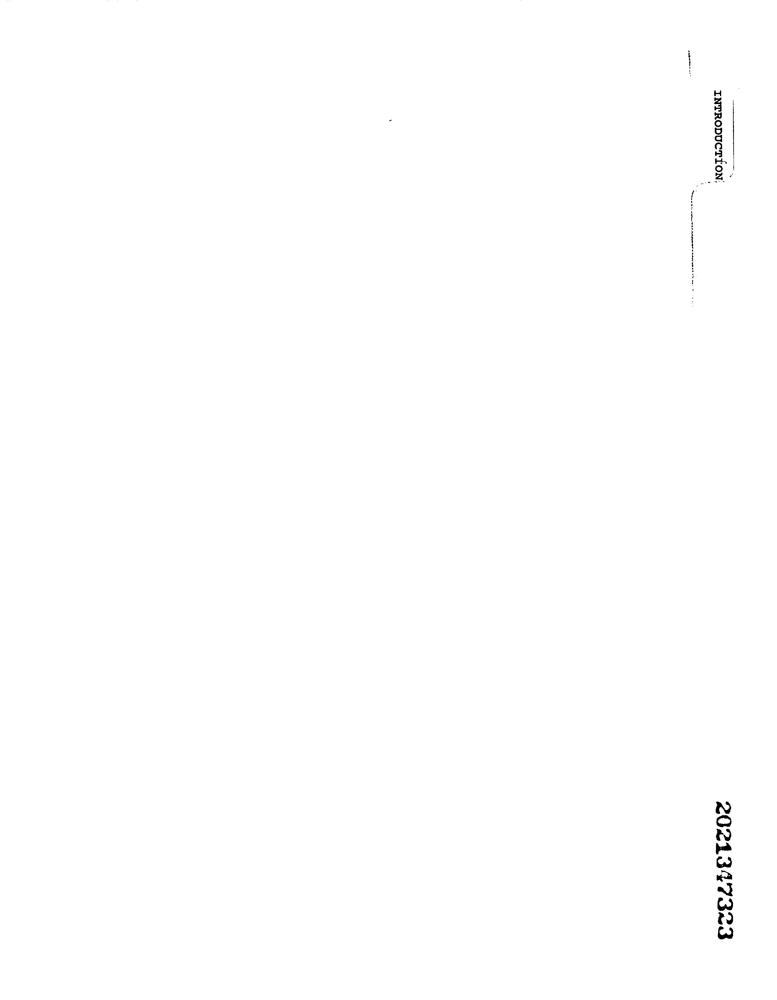

In [130]:
ds['train'][2]['image']

#### Show Class of Example

In [131]:
class_label_number = ds['train'][2]['label']
print(class_label_number)

7


#### Class Name for Example

In [132]:
label_names = dataset['train'].features['label'].names
print(id2label[class_label_number])

presentation


#### Basic Values/Constants

In [133]:
MODEL_CKPT = "microsoft/dit-base"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Business_Documents_Classified"

NUM_OF_EPOCHS=10
LEARNING_RATE=5e-5

BATCH_SIZE=32
DEVICE = torch.device("cuda") 

REPORTS_TO='tensorboard'
STRATEGY = "epoch"

#### Instantiate Feature Extractor

In [134]:
feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_CKPT)
feature_extractor

/usr/local/lib/python3.9/dist-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/beit/image_processing_beit.py:108: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


BeitFeatureExtractor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "BeitFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

#### Create Functions to Transform Datasets for Training & Evaluation

In [135]:
# normalize
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

# train_transforms
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size['height'], feature_extractor.size['width'])),# it was a list that used [], not ()
            RandomHorizontalFlip(),
            ToTensor(),
            normalize
        ]
    )

# eval_transforms
val_transforms = Compose(
        [
            Resize((feature_extractor.size['height'], feature_extractor.size['width'])),
            CenterCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """
    Apply train_transforms across a batch
    """
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """
    Apply val_transforms across a batch
    """
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

#### Apply Preprocessing Functions to Appropriate Datasets

In [136]:
ds['train'].set_transform(preprocess_train)
ds['eval'].set_transform(preprocess_val)

#### Display Example of Preprocessed Document

In [137]:
ds['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=754x1000 at 0x7F8CE77BED60>,
 'label': 10,
 'pixel_values': tensor([[[0.7176, 0.6627, 0.8667,  ..., 1.0000, 1.0000, 1.0000],
          [0.9686, 0.9765, 0.9843,  ..., 1.0000, 1.0000, 1.0000],
          [0.9686, 0.9765, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.7176, 0.6627, 0.8667,  ..., 1.0000, 1.0000, 1.0000],
          [0.9686, 0.9765, 0.9843,  ..., 1.0000, 1.0000, 1.0000],
          [0.9686, 0.9765, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.7176, 0.6627, 0.8667,  ..., 1.0000, 1

#### Instantiate Model

In [138]:
model = AutoModelForImageClassification.from_pretrained(
    MODEL_CKPT,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
).to(DEVICE)

Some weights of the model checkpoint at microsoft/dit-base were not used when initializing BeitForImageClassification: ['lm_head.weight', 'layernorm.weight', 'layernorm.bias', 'lm_head.bias']
- This IS expected if you are initializing BeitForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BeitForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/dit-base and are newly initialized: ['beit.pooler.layernorm.weight', 'classifier.bias', 'beit.pooler.layernorm.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it

#### Define Training Arguments

In [139]:
args = TrainingArguments(
    MODEL_NAME,
    remove_unused_columns=False,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    logging_strategy="steps",
    logging_steps=8,
    logging_first_step=True,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    num_train_epochs=NUM_OF_EPOCHS,
    warmup_ratio=0.10,
    report_to=REPORTS_TO,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Function to Compute Metrics

In [140]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                       references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                                references=p.label_ids, 
                                                average='weighted')["f1"]

    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                             references=p.label_ids, 
                                             average='micro')['f1']

    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                             references=p.label_ids, 
                                             average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                            references=p.label_ids, 
                                            average='weighted')["recall"]

    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                         references=p.label_ids, 
                                         average='micro')["recall"]

    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                         references=p.label_ids, 
                                         average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                                  references=p.label_ids, 
                                                  average='weighted')["precision"]
                                                  
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                               references=p.label_ids, 
                                               average='micro')["precision"]

    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                               references=p.label_ids, 
                                               average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Define Data Collation Function

In [141]:
def collate_fn(examples):
    pixel_values = torch.stack([example['pixel_values'] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

#### Instantiate Trainer

In [142]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds['train'], 
    eval_dataset=ds['eval'], 
    tokenizer=feature_extractor, 
    compute_metrics=compute_metrics, 
    data_collator=collate_fn
)

Cloning https://huggingface.co/DunnBC22/dit-base-Business_Documents_Classified into local empty directory.


#### Train Model & Save/Log Relevant Metrics

In [143]:
train_results = trainer.train()

trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Weighted f1,Micro f1,Macro f1,Weighted recall,Micro recall,Macro recall,Weighted precision,Micro precision,Macro precision
0,2.592000,2.262190,0.301000,0.271298,0.301000,0.280951,0.301000,0.301000,0.312585,0.303746,0.301000,0.312375
1,1.924600,1.555552,0.547000,0.529757,0.547000,0.537522,0.547000,0.547000,0.554453,0.561342,0.547000,0.567545
2,1.496000,1.201088,0.633000,0.632975,0.633000,0.638313,0.633000,0.633000,0.642582,0.652307,0.633000,0.655582
4,1.273900,1.001102,0.716000,0.713477,0.716000,0.720737,0.716000,0.716000,0.722680,0.719394,0.716000,0.727889
4,1.155100,0.921439,0.729000,0.730323,0.729000,0.738633,0.729000,0.729000,0.735358,0.741254,0.729000,0.751742
5,1.049100,0.852777,0.760000,0.760869,0.760000,0.767124,0.760000,0.760000,0.764828,0.769076,0.760000,0.777252
6,1.058100,0.825641,0.765000,0.763485,0.765000,0.768735,0.765000,0.765000,0.769519,0.767933,0.765000,0.774084
8,0.966500,0.815692,0.758000,0.756734,0.758000,0.761699,0.758000,0.758000,0.761024,0.764356,0.758000,0.771777
8,0.918000,0.792458,0.766000,0.763813,0.766000,0.768575,0.766000,0.766000,0.768968,0.768694,0.766000,0.776021
9,0.981300,0.785150,0.767000,0.765128,0.767000,0.770399,0.767000,0.767000,0.770690,0.769149,0.767000,0.776709


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/327M [00:00<?, ?B/s]

Upload file runs/Apr19_01-09-00_1962df9fc2fb/events.out.tfevents.1681866552.1962df9fc2fb.329.0:   0%|         …

To https://huggingface.co/DunnBC22/dit-base-Business_Documents_Classified
   5777a48..e609aa5  main -> main

   5777a48..e609aa5  main -> main

To https://huggingface.co/DunnBC22/dit-base-Business_Documents_Classified
   e609aa5..6b68a9a  main -> main

   e609aa5..6b68a9a  main -> main



***** train metrics *****
  epoch                    =         9.92
  total_flos               = 2864399720GF
  train_loss               =       1.3828
  train_runtime            =   0:52:17.21
  train_samples_per_second =        12.75
  train_steps_per_second   =        0.099


#### Push Model to Hub (My Profile!!!)

In [144]:
trainer.push_to_hub()

To https://huggingface.co/DunnBC22/dit-base-Business_Documents_Classified
   6b68a9a..b114923  main -> main

   6b68a9a..b114923  main -> main



'https://huggingface.co/DunnBC22/dit-base-Business_Documents_Classified/commit/b11492377b260a2c8bcfd187ade701e2e7e9005c'

#### Evaluate Model

In [145]:
metrics = trainer.evaluate()

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       9.92
  eval_Macro F1           =     0.7704
  eval_Macro Precision    =     0.7767
  eval_Macro Recall       =     0.7707
  eval_Micro F1           =      0.767
  eval_Micro Precision    =      0.767
  eval_Micro Recall       =      0.767
  eval_Weighted F1        =     0.7651
  eval_Weighted Precision =     0.7691
  eval_Weighted Recall    =      0.767
  eval_accuracy           =      0.767
  eval_loss               =     0.7851
  eval_runtime            = 0:00:23.74
  eval_samples_per_second =     42.122
  eval_steps_per_second   =      1.348


### Notes & Other Takeaways From This Project
****
- 

****

### Citations

- Model Checkpoint:
    - @misc{li2022dit,
        title={DiT: Self-supervised Pre-training for Document Image Transformer},
        author={Junlong Li and Yiheng Xu and Tengchao Lv and Lei Cui and Cha Zhang and Furu Wei},
        year={2022},
        eprint={2203.02378},
        archivePrefix={arXiv},
        primaryClass={cs.CV}
    }